In [127]:
import torch 
import torch.nn as nn
import torch.optim as optim

from utils import *
from models import *

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
d = 3
m = 8
t = 200
b = 1000
lamda = 0.2
distance = 0.1
coherent = False

array = ULA(m, lamda)
array.build_array(distance)
array.build_array_manifold()

theta = torch.rand(d) * torch.pi - torch.pi / 2
A = array.get_steering_vector(theta)

loss_cpu = MSPE(d, 'cpu')
loss_cuda = MSPE(d, dev)

In [131]:
SNRs = [0, 5, 10, 15, 20]
methods = ["MUSIC", "Root-MUSIC", "DA-MUSIC", "DA-MUSIC v2", "RNN", "CLRB"]
values = {
    "MUSIC": [],
    "Root-MUSIC": [],
    "DA-MUSIC": [],
    "DA-MUSIC v2": [],
    "RNN": [],
    "CLRB": []
}

path = 'saved_models_rmspe/'

for snr in SNRs:

    x = (torch.randn(b, d, t) + 1j * torch.randn(b, d, t)) / sqrt(2) * 10 ** (snr / 20) * 0.1
    n = (torch.randn(b, m, t) + 1j * torch.randn(b, m, t)) / sqrt(2) * 0.1
    y = A @ x + n
    y = y.transpose(1, 2).to(dev)

    da_music = DA_MUSIC(m, d, array, dev)
    da_music.load_state_dict(torch.load(path+'da_music_'+str(snr)+'dB.pth', weights_only=True))
    values['DA-MUSIC'].append(loss_cuda(da_music(y), theta.unsqueeze(0).cuda()).float().cpu().detach().numpy())

    da_music_v2 = DA_MUSIC_v2(m, d, array, dev)
    da_music_v2.load_state_dict(torch.load(path+'da_music_v2_'+str(snr)+'dB.pth', weights_only=True))
    values['DA-MUSIC v2'].append(loss_cuda(da_music_v2(y), theta.unsqueeze(0).cuda()).float().cpu().detach().numpy())

    rnn = RNN(m, d, dev)
    rnn.load_state_dict(torch.load(path+'rnn_'+str(snr)+'dB.pth', weights_only=True))
    values['RNN'].append(loss_cuda(rnn(y), theta.unsqueeze(0).cuda()).float().cpu().detach().numpy())

    results_music = torch.zeros(b, d)
    array.x = array.x.cpu()
    array.y = array.y.cpu()

    for i in range(b):
        results_music[i] = MUSIC(y[i].T.cpu(), d, array)[0]

    values['MUSIC'].append(loss_cpu(results_music, theta.unsqueeze(0)).float().cpu().detach().numpy())

    values['Root-MUSIC'].append(loss_cpu(Root_MUSIC(y, d, array).cpu(), theta.unsqueeze(0)).float().cpu().detach().numpy())

    sources_cov = torch.eye(d, dtype=torch.complex64) * 10 ** (snr / 10) * 0.1 * 0.1
    noise_sigma2 = 0.1 * 0.1
    crb = CRLB(array, theta.squeeze(0).cpu(), sources_cov, noise_sigma2, t)
    values['CLRB'].append(torch.mean(torch.diag(crb)).float().cpu().detach().numpy())

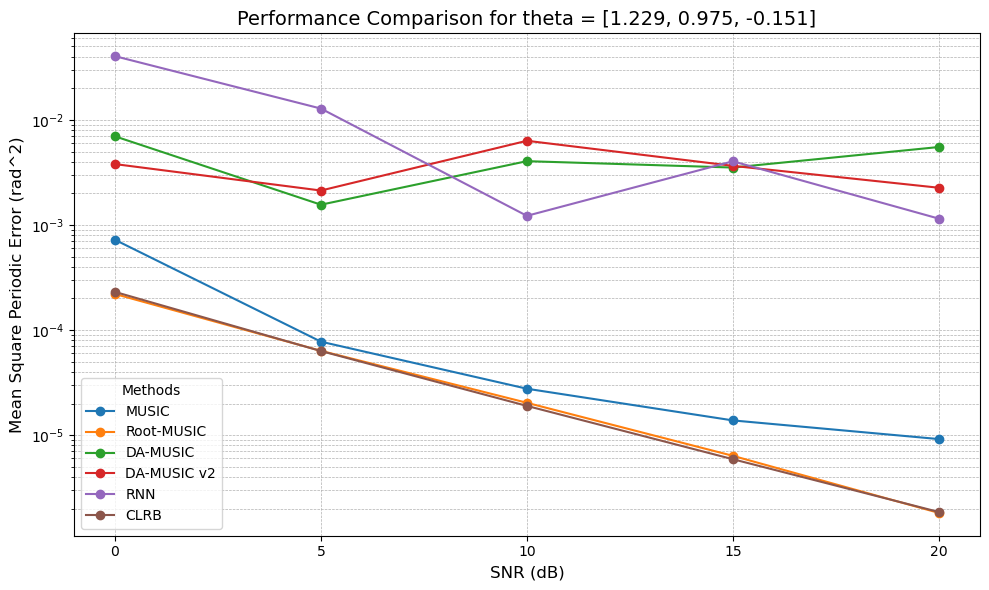

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Plot
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(SNRs, values[method], marker='o', label=method)

# Customizing the plot
plt.yscale("log")
plt.title("Performance Comparison for theta = {}".format([round(float(a), 3) for a in list(theta)]), fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Mean Square Periodic Error (rad^2)", fontsize=12)
plt.xticks(SNRs)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Methods")
plt.tight_layout()

# Show plot
plt.show()